In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch


In [2]:
d_sorts = ["CD-GraB", "D-RR"]


In [3]:
def exp_maker(n, sorter, seed):
    return f"sorter-{sorter}-node-{n}-lr-0.001-B-16-seed-{seed}-nhid-64-nlayers-3"


In [4]:
results = {s: [] for s in d_sorts}
times = {s: [] for s in d_sorts}

for s in d_sorts:
    for seed in range(5):
        exp_details = exp_maker(4, s, seed)
        exp_folder = f"..{os.sep}..{os.sep}results{os.sep}M4{os.sep}{exp_details}"
        r = torch.load(f"{exp_folder}{os.sep}results.pt" , map_location='cpu')
        results[s].append(r)
        for rank in range(4):
            time_folder = f"{exp_folder}{os.sep}time"
            times[s].append(torch.load(f"{time_folder}time-{rank}.pt", map_location='cpu'))

In [5]:
def down_sampling(len_sampling, data):
    start = 0
    end = len_sampling
    len_data = len(data)
    ret = []
    while end <= len_data:
        data_chunk = data[start:end]
        start += len_sampling
        end += len_sampling
        ret.append(torch.mean(torch.as_tensor(data_chunk)))
    return torch.as_tensor(ret)

In [21]:
def plot_res(ax, s, label, train_test, loss_acc, downsample=False):
    res = []
    for arr in results[s]:
        if downsample:
            if train_test == 'train':
                res.append(down_sampling(2, torch.tensor(arr[train_test][loss_acc])).square())
            else:
                res.append(down_sampling(2, torch.tensor(arr[train_test][loss_acc])))
        else:            
            if train_test == 'train':
                res.append(torch.tensor(arr[train_test][loss_acc]).square())
            else:
                res.append(torch.tensor(arr[train_test][loss_acc]))
    end_pos = len(torch.tensor(results[s][0][train_test][loss_acc])) + 1
    if downsample:
        step = 2
    else:
        step = 1
    res = torch.vstack(res).numpy()
    mean = res.mean(axis=0)
    std = res.std(axis=0)
    ax.plot(np.arange(1, end_pos, step), mean, label=label, markersize=5)
    ax.fill_between(
        np.arange(1, end_pos, step), (mean - std), (mean + std), alpha=0.1)


/tmp/ipykernel_563775/1833042824.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


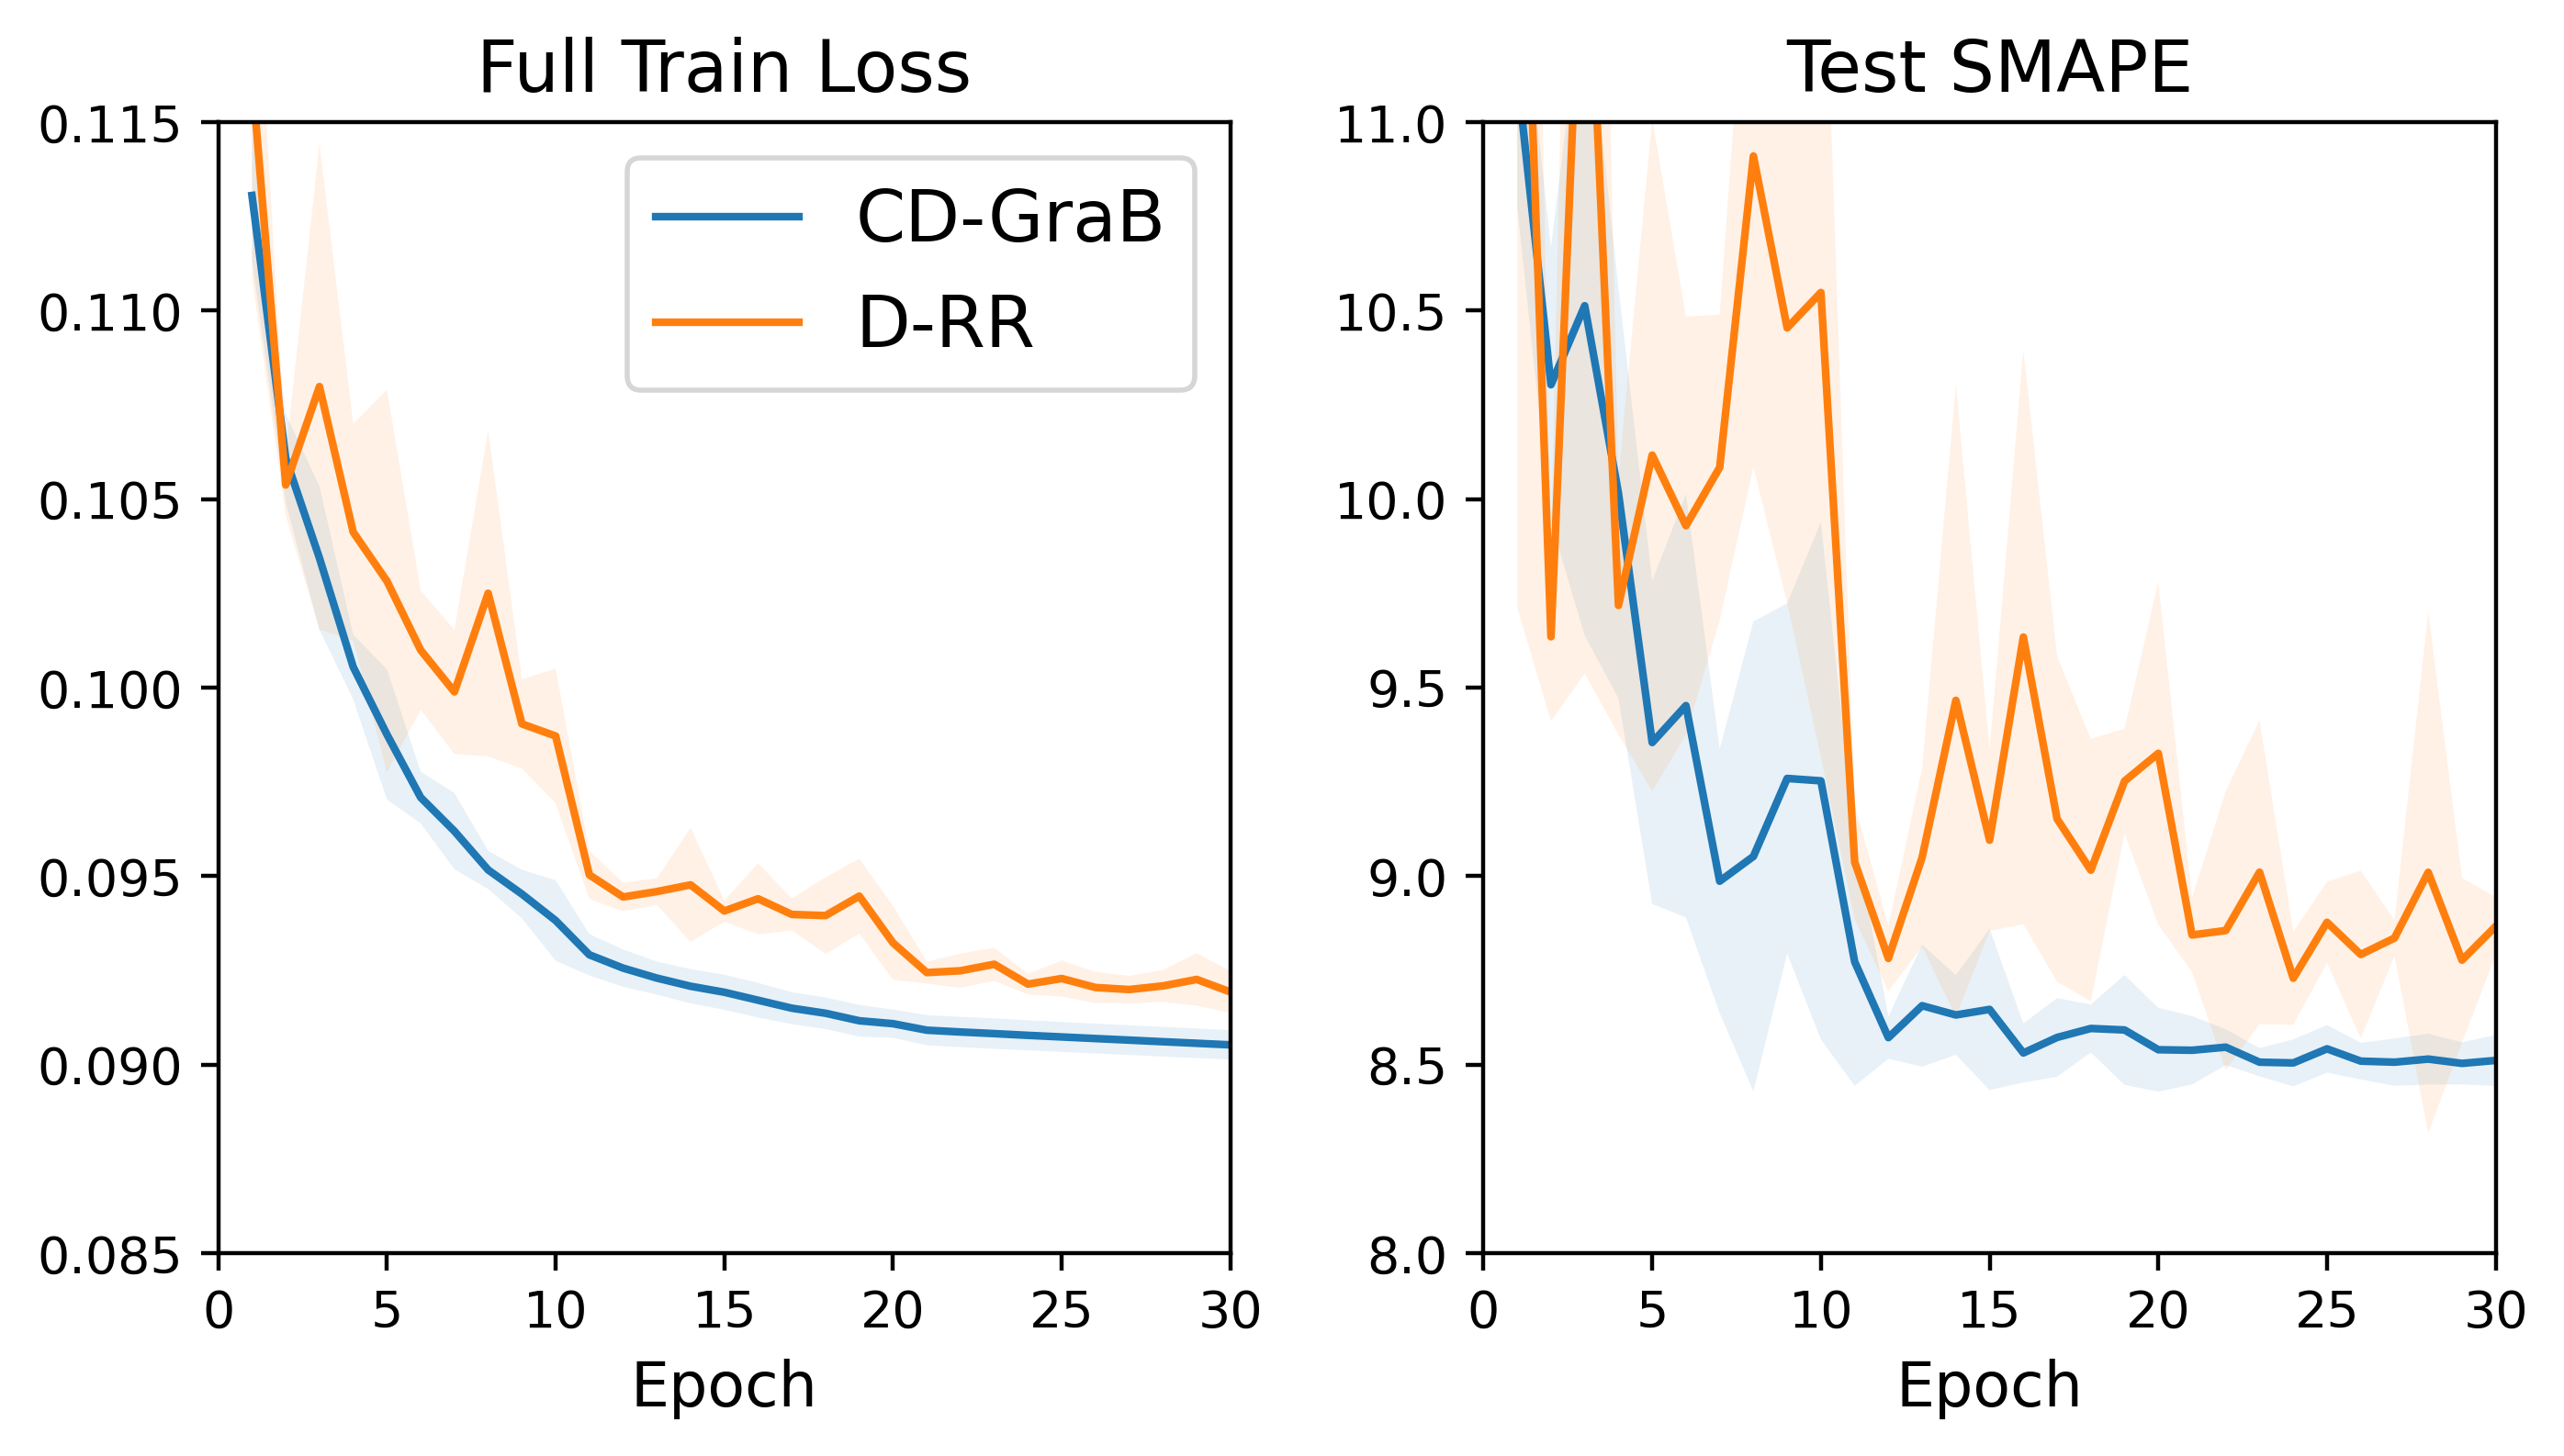

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=400, gridspec_kw=dict(wspace=0.25), sharex=True)

plot_res(axes[0], "CD-GraB", "CD-GraB", "train", "rmse")
plot_res(axes[0], "D-RR", "D-RR", "train", "rmse")

axes[0].legend(fontsize=14, loc='upper right')
axes[0].set_title('Full Train Loss', fontsize=14)
axes[0].set_ylim(0.085, 0.115)
axes[0].set_xlabel('Epoch', fontsize=12)

plot_res(axes[1], "CD-GraB", "CD-GraB", "test", "smape", downsample=False)
plot_res(axes[1], "D-RR", "D-RR", "test", "smape", downsample=False)

axes[1].set_title('Test SMAPE', fontsize=14)
axes[1].set_ylim(8, 11)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_xlim(0, 30)
fig.tight_layout()
fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}M4-epoch-1.png')

In [35]:
def plot_time(ax, s, label, train_test, loss_acc, dasheddot=True):
    res = []
    for arr in results[s]:          
        if train_test == 'train':
            res.append(torch.tensor(arr[train_test][loss_acc]).square())
        else:
            res.append(torch.tensor(arr[train_test][loss_acc]))
    res = torch.vstack(res).numpy()
    time_res = []
    for time_arr in times[s]:
        one_time = []
        for e in range(1, res.shape[1] + 1):
            one_time.append(sum(time_arr[f'epoch-{e}']))
        one_time = torch.tensor(one_time) / 1000
        time_res.append(torch.cumsum(one_time, dim=0))
    time_res = torch.vstack(time_res).numpy()
    time_res = time_res.mean(axis=0)
    mean = res.mean(axis=0)
    std = res.std(axis=0)
    ax.plot(time_res, mean, label=label, markersize=5)
    ax.fill_between(
        time_res, (mean - std), (mean + std), alpha=0.1)


/tmp/ipykernel_563775/2134479182.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


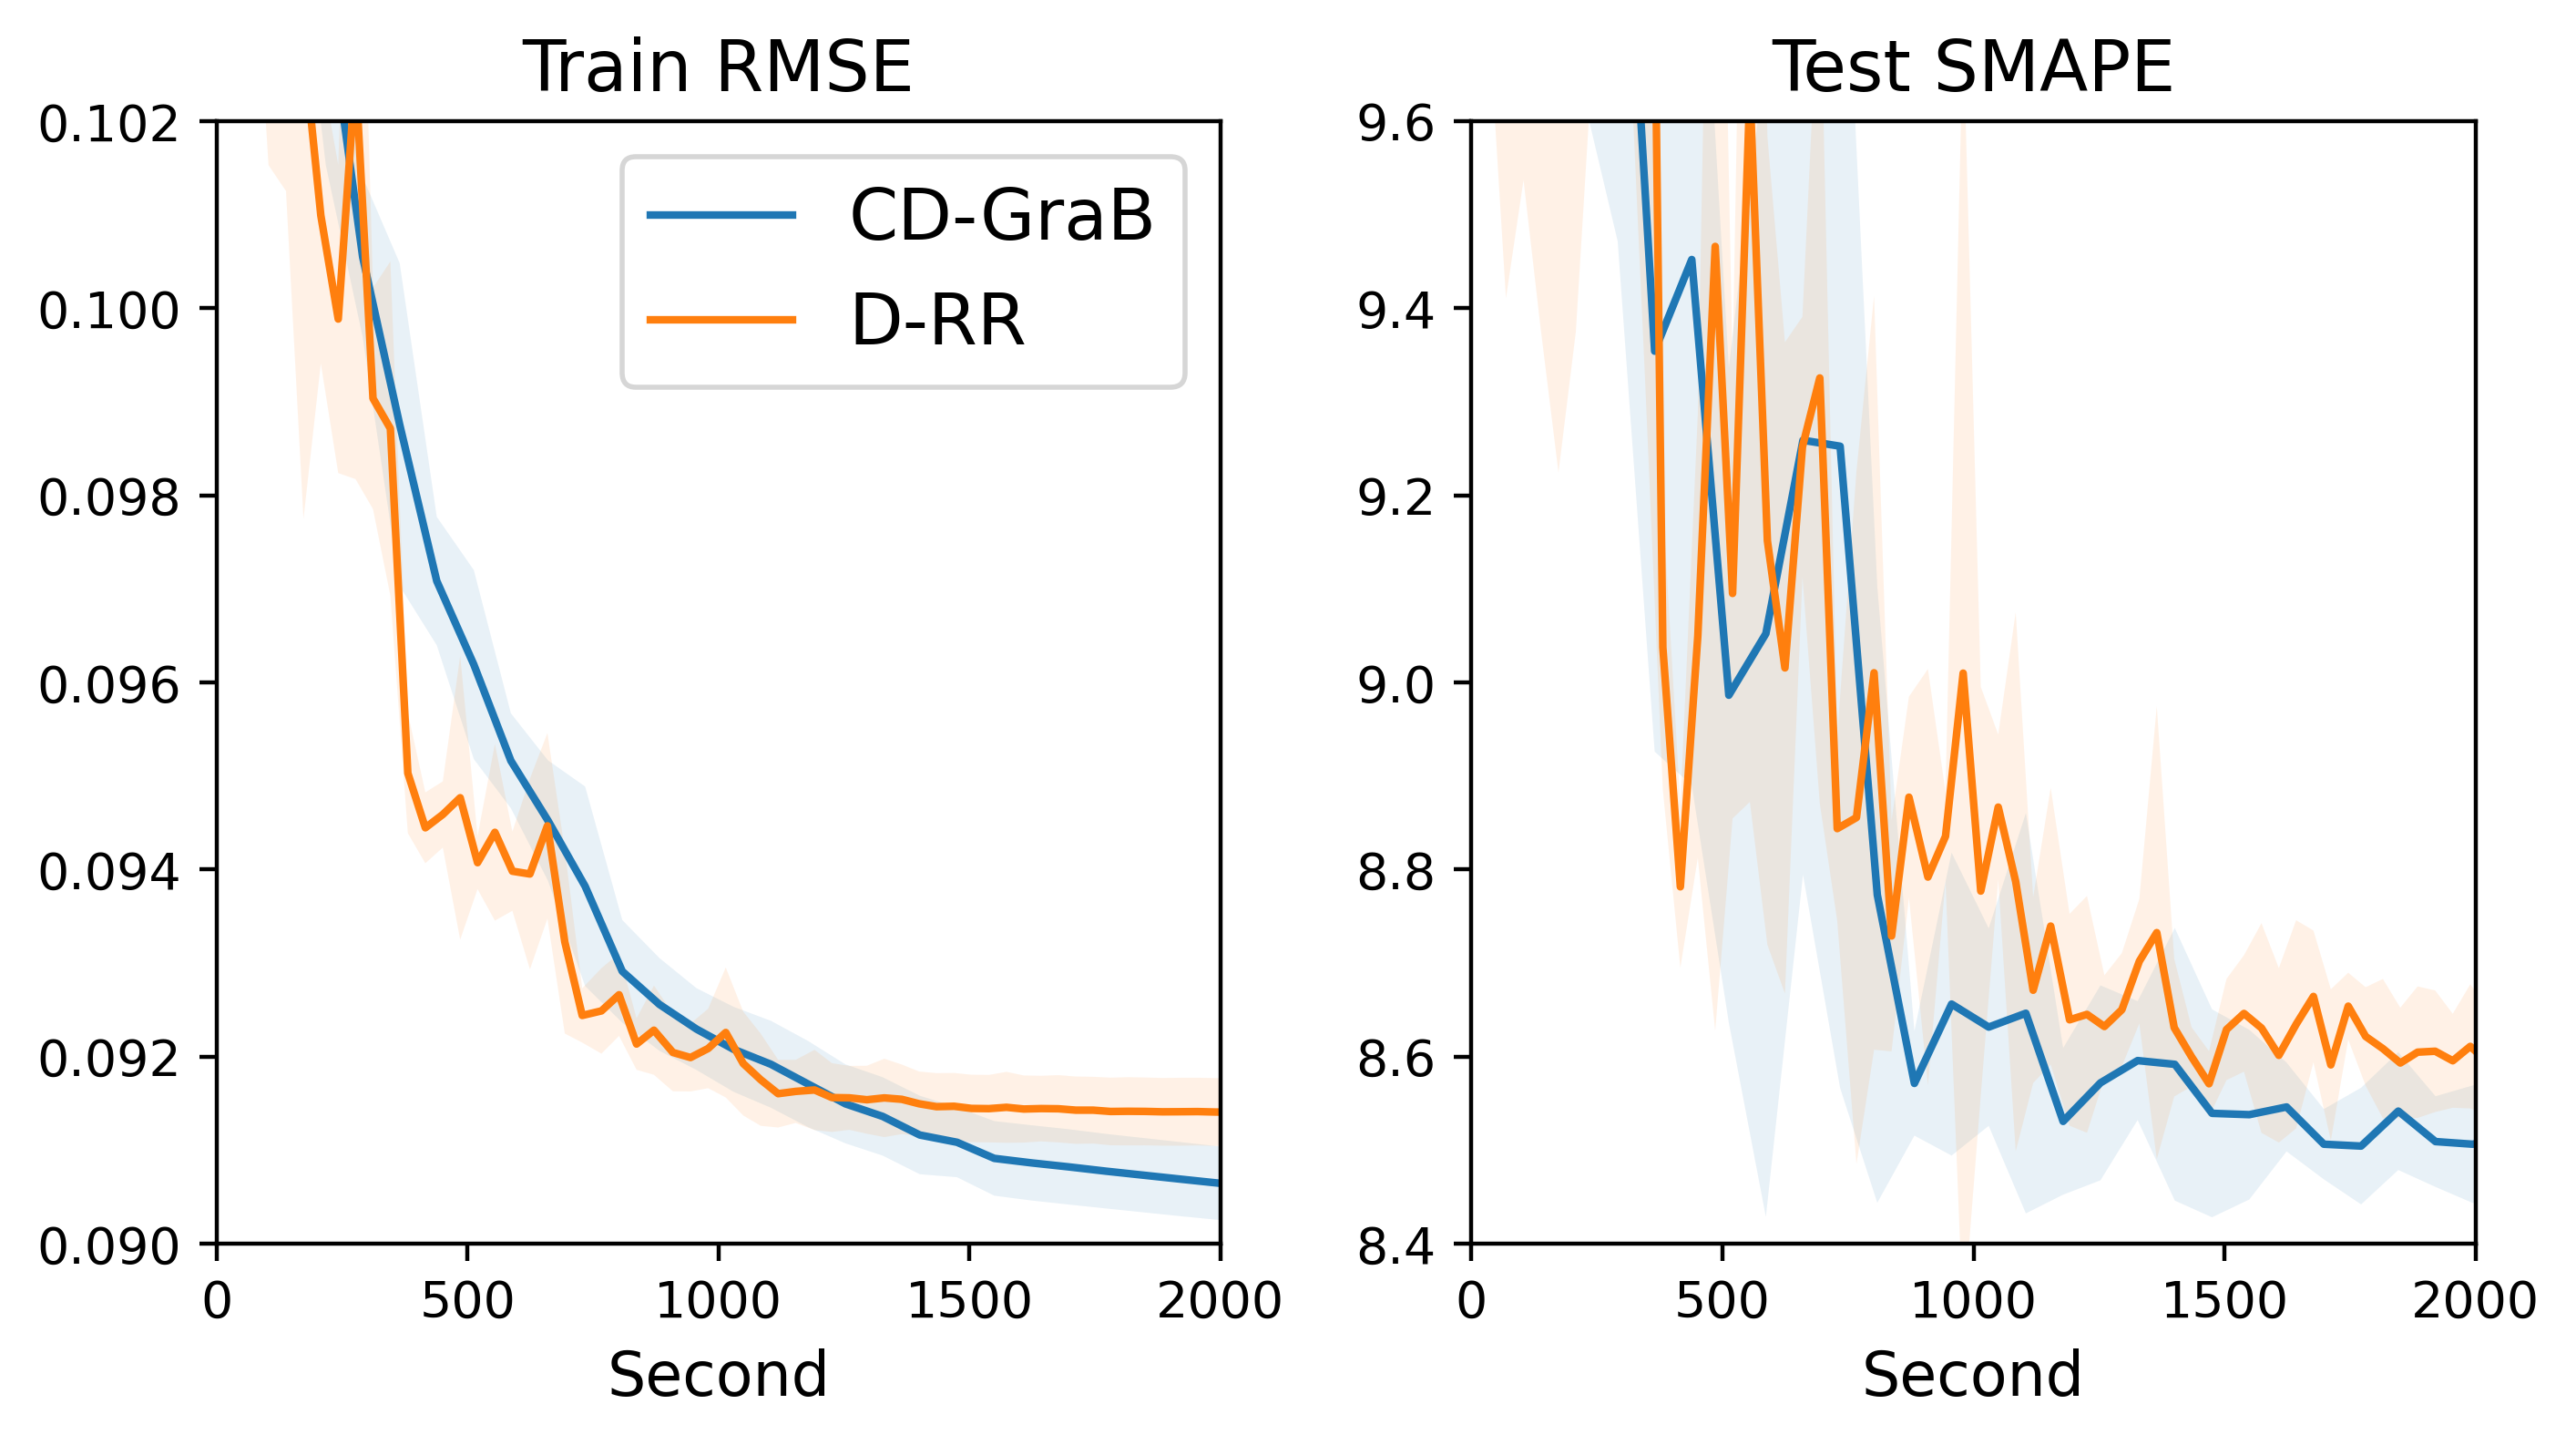

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(
    8, 4), dpi=400, gridspec_kw=dict(wspace=0.25),sharex=True)

plot_time(axes[0], "CD-GraB", "CD-GraB", "train", "rmse", dasheddot=False)
plot_time(axes[0], "D-RR", "D-RR", "train", "rmse")

axes[0].legend(fontsize=14, loc='upper right')
axes[0].set_title('Train RMSE', fontsize=14)
axes[0].set_ylim(0.09, 0.102)
axes[0].set_xlabel('Second', fontsize=12)


plot_time(axes[1], "CD-GraB", "CD-GraB", "test", "smape", dasheddot=False)
plot_time(axes[1], "D-RR", "D-RR", "test", "smape")

axes[1].set_title('Test SMAPE', fontsize=14)
axes[1].set_ylim(8.4, 9.6)
axes[1].set_xlabel('Second', fontsize=12)
axes[1].set_xlim(0, 2000)
fig.tight_layout()
fig.savefig(f'..{os.sep}..{os.sep}graph{os.sep}M4-second-1.png')